In [1]:
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage import color, io
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


In [2]:
# ## Obtain all folders (without README and .csv) and keep them in order by starting with mask
            
brain_imgs = []
brain_masks = glob('archive/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for file in brain_masks:
    brain_imgs.append(file.replace('_mask',''))            

In [3]:
has_tumor = []

for mask in brain_masks:
    tumor = np.max(cv2.imread(mask))
    if tumor == 0:
        has_tumor.append(0)
    else:
        has_tumor.append(1)

brain_df = pd.DataFrame(data={"Image File": brain_imgs, "Mask File": brain_masks, "Tumor Detected": has_tumor})

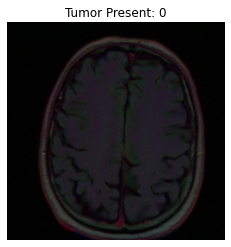

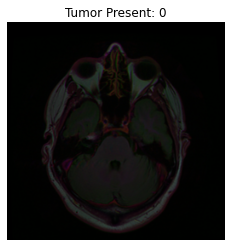

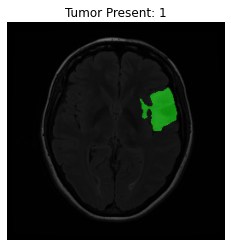

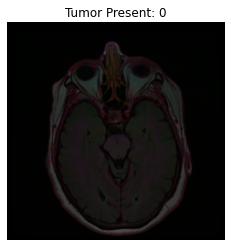

In [4]:
for x in range(4):
    i = random.randint(0, len(brain_df)) # select a random index
    plt.figure(x)
    image = cv2.imread(brain_df["Image File"][i])
    mask = cv2.imread(brain_df["Mask File"][i])
    if brain_df['Tumor Detected'][i] == 1:
        indices = np.where(mask==255)
        mask[indices[0], indices[1], :] = [0, 255, 0]
    plt.imshow(image)
    plt.imshow(mask,cmap='jet',alpha=0.5)
    plt.title("Tumor Present: "+ str(brain_df['Tumor Detected'][i]))
    plt.axis('off')

In [5]:
brain_train, brain_test = train_test_split(brain_df, test_size = 0.15)
brain_train, brain_val = train_test_split(brain_train, test_size = 0.2)

In [6]:
print(brain_train.shape)
print(brain_test.shape)
print(brain_val.shape)

(2671, 3)
(590, 3)
(668, 3)


In [7]:
#Source for UNet paramaters: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "Image File",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "Mask File",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)
    
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)



In [8]:
# Loss functions sourced from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

smooth = 100

def dsc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac



In [9]:
##Unet Model from https://github.com/zhixuhao/unet/blob/master/model.py

def unet(input_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    batch1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    batch2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch2)
    batch2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    batch3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch3)
    batch3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    batch4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch4)
    batch4 = BatchNormalization(axis=3)(conv4)
    drop4 = Dropout(0.5)(batch4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    batch5 = BatchNormalization(axis=3)(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch5)
    batch5 = BatchNormalization(axis=3)(conv5)
    drop5 = Dropout(0.5)(batch5)

    up6 = Conv2DTranspose(512, 2, strides=(2,2),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    batch6 = BatchNormalization(axis=3)(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    batch7 = BatchNormalization(axis=3)(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    batch8 = BatchNormalization(axis=3)(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    batch9 = BatchNormalization(axis=3)(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(batch9)

    model = Model(inputs = inputs, outputs = conv10,name="unet")

    return model

In [10]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(brain_train[["Image File","Mask File"]], 32,
                                train_generator_args,
                                target_size=(64, 64))

test_gen = train_generator(brain_test[["Image File","Mask File"]], 32,
                                dict(),
                                target_size=(64, 64))
    
val_gen = train_generator(brain_val[["Image File","Mask File"]], 32,
                                dict(),
                                target_size=(64, 64))
    
model = unet((64, 64, 3))
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d_1[0][0]']               
 alization)                                                                                    

 conv2d_12 (Conv2D)             (None, 16, 16, 256)  1179904     ['concatenate_1[0][0]']          
                                                                                                  
 conv2d_13 (Conv2D)             (None, 16, 16, 256)  590080      ['conv2d_12[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 32, 32, 128)  131200     ['batch_normalization_10[0][0]'] 
 spose)                                                                                           
                                                                                                  
 concatena

In [11]:
K.clear_session()
adam = Adam(learning_rate = 0.01,epsilon=0.1)
model.compile(optimizer = adam, 
                  loss = [dice_loss,focal_tversky], 
                  metrics = ["binary_accuracy", dsc,tversky,iou]
                 )

In [12]:
history = model.fit(train_gen, 
                 steps_per_epoch=len(brain_train)/128,
                 epochs = 60, 
                 validation_data = val_gen,
                 validation_steps = len(brain_val)/128
                 )

Found 2671 validated image filenames.
Found 2671 validated image filenames.
Epoch 1/60
21/20 [==============================] - ETA: 0s - loss: 0.9796 - binary_accuracy: 0.5253 - dsc: 0.0204 - tversky: 0.0355 - iou: 0.0111Found 668 validated image filenames.
Found 668 validated image filenames.
20/20 [==============================] - 130s 5s/step - loss: 0.9796 - binary_accuracy: 0.5253 - dsc: 0.0204 - tversky: 0.0355 - iou: 0.0111 - val_loss: 0.9770 - val_binary_accuracy: 0.8768 - val_dsc: 0.0230 - val_tversky: 0.0395 - val_iou: 0.0124
Epoch 2/60
20/20 [==============================] - 71s 3s/step - loss: 0.9751 - binary_accuracy: 0.5315 - dsc: 0.0249 - tversky: 0.0426 - iou: 0.0134 - val_loss: 0.9781 - val_binary_accuracy: 0.8420 - val_dsc: 0.0219 - val_tversky: 0.0378 - val_iou: 0.0119
Epoch 3/60
20/20 [==============================] - 52s 2s/step - loss: 0.9698 - binary_accuracy: 0.5408 - dsc: 0.0302 - tversky: 0.0510 - iou: 0.0161 - val_loss: 0.9800 - val_binary_accuracy: 0.751

In [13]:
results = model.evaluate(test_gen, steps=len(brain_test)/32)

Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 29s 2s/step - loss: 0.2576 - binary_accuracy: 0.9950 - dsc: 0.7344 - tversky: 0.7390 - iou: 0.6029


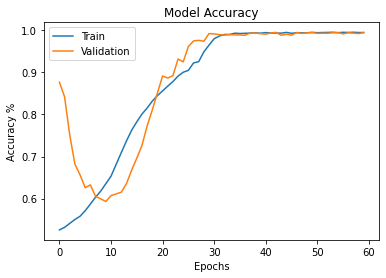

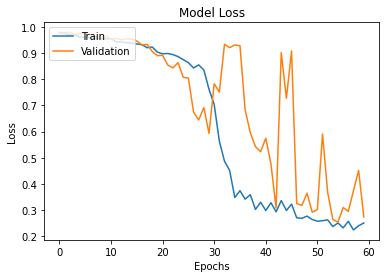

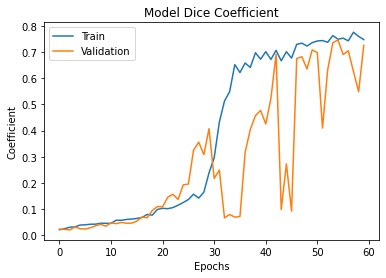

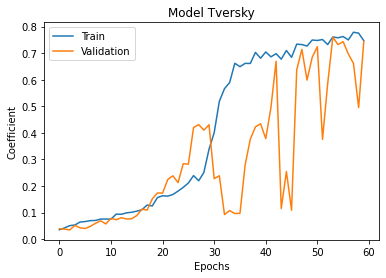

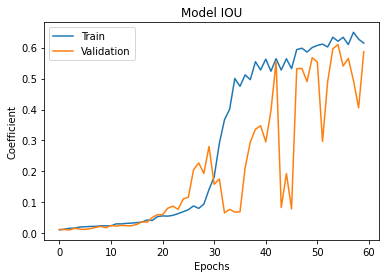

In [17]:
plt.figure(1)
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["Train","Validation"],loc="upper left")

plt.figure(2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Validation"],loc="upper left")

plt.figure(3)
plt.plot(history.history["dsc"])
plt.plot(history.history["val_dsc"])
plt.title("Model Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Coefficient")
plt.legend(["Train","Validation"],loc="upper left")

plt.figure(4)
plt.plot(history.history["tversky"])
plt.plot(history.history["val_tversky"])
plt.title("Model Tversky")
plt.xlabel("Epochs")
plt.ylabel("Coefficient")
plt.legend(["Train","Validation"],loc="upper left")

plt.figure(5)
plt.plot(history.history["iou"])
plt.plot(history.history["val_iou"])
plt.title("Model IOU")
plt.xlabel("Epochs")
plt.ylabel("Coefficient")
plt.legend(["Train","Validation"],loc="upper left")

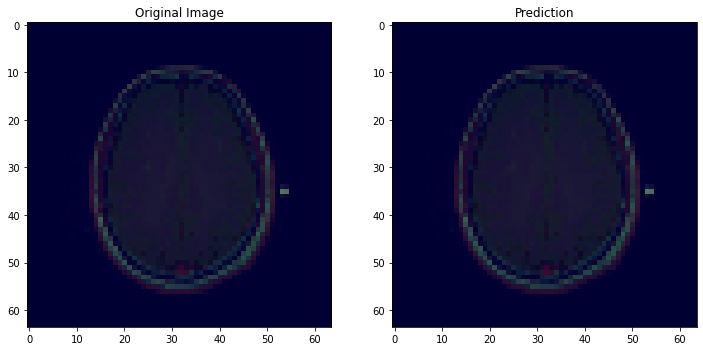

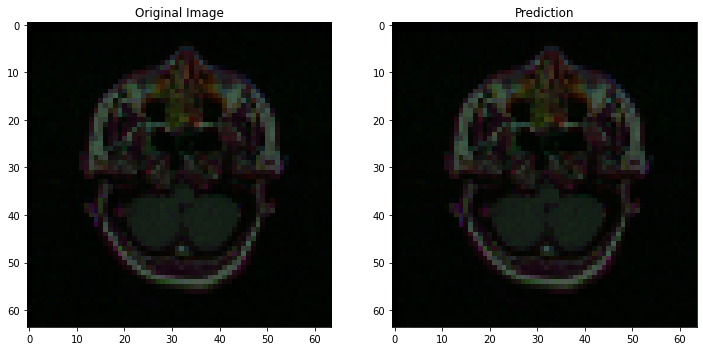

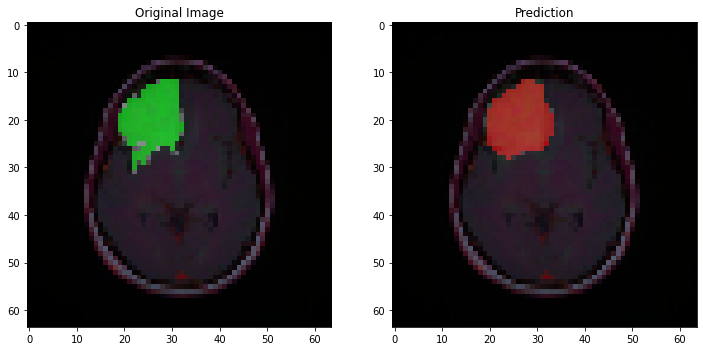

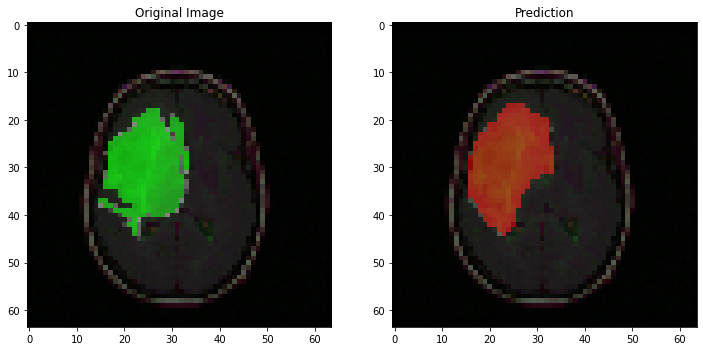

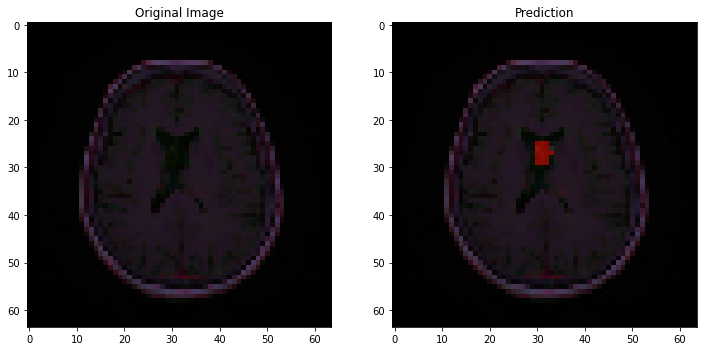

In [25]:
for i in range(5):
    index=np.random.randint(1,len(brain_test.index))
    img = cv2.imread(brain_test['Image File'].iloc[index])
    img = cv2.resize(img ,(64, 64))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    mask = cv2.imread(brain_test['Mask File'].iloc[index])
    mask = cv2.resize(mask,(64,64))
    indices = np.where(mask==255)
    mask[indices[0], indices[1], :] = [0, 255, 0]
    plt.imshow(np.squeeze(mask),cmap='jet',alpha=0.5)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(img))
    pred = np.repeat(pred, 3, axis=-1)
    pred = np.squeeze(pred)
    indices = np.where(pred>.5)
    pred[indices[0], indices[1], :] = [1, 0, 0]
    plt.imshow(pred,cmap='jet',alpha=0.5)
    
    plt.title('Prediction')
    plt.show()